In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import kid_readout.roach.baseband
import kid_readout.utils.sweeps

In [23]:
import kid_readout.analysis.resonator

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [19]:
import time

In [3]:
ri = kid_readout.roach.baseband.RoachBaseband()

Loaded ROACH state from /data/readout/roach_config.npz


In [4]:
ri.set_dac_atten(41)

In [36]:
res = np.load('/home/gjones/kid_readout/apps/sc5x4_0813f12b.npy')[[0,1,2,3,4,5,6,7,8,9,10,13,14,15,16,17]]

In [37]:
np.diff(res)

array([  7.147086,   1.641977,   5.967523,  11.223883,   5.815117,
         2.342109,   4.453125,   3.495118,  14.299804,   0.590821,
         0.577148,   6.663875,   8.301945,   6.072266,   3.56543 ])

In [38]:
res.shape

(16,)

In [39]:
256e6/2**18

976.5625

In [40]:
blah = kid_readout.utils.sweeps.prepare_sweep(ri,res,np.arange(-80,21)*256./2**18,nsamp=2**18)

bank_offset= 0 start_offset= 0 start_offset_bytes= 0
writing DRAM bank 0

writing DRAM bank 1



In [41]:
tic = time.time()
swp = kid_readout.utils.sweeps.do_prepared_sweep(ri,nchan_per_step=16)
print time.time()-tic

detected mcnt overflow None 2400321 0 16384 0 48 2400321
detected mcnt overflow None 303166 0 16384 0 496 303166
detected mcnt overflow None 2007101 0 16384 0 352 2007101
77.7269859314


In [42]:
def fit_sweeps(swp):
    resonators = []
    lo = swp.blocks[0].lo
    fig,axs = subplots(4,4,figsize=(12,12))
    fig2,axs2 = subplots(4,4,figsize=(12,12))
    for k in range(swp.sweep_indexes.max()+1):
        fr,s21,err = swp.select_index(k)
        ax = axs.flatten()[k]
        fr,s21,err = swp.select_index(k)
        s21c = s21*np.exp(swp.hardware_delay_estimate*1e6j*2*np.pi*(fr-swp.lo[0]))
        res = kid_readout.analysis.resonator.fit_best_resonator(fr,s21c,errors=err,min_a=1.0)
        ax.plot(s21c.real,s21c.imag,'.-')
        modl = res.model(x=fr)
        ax.plot(modl.real,modl.imag,'.-')
        ax2 = axs2.flatten()[k]
        ax2.plot(fr,20*np.log10(np.abs(s21c)),'.-')
        ax2.plot(fr,20*np.log10(np.abs(modl)),'.-')
        resonators.append(res)
    return resonators

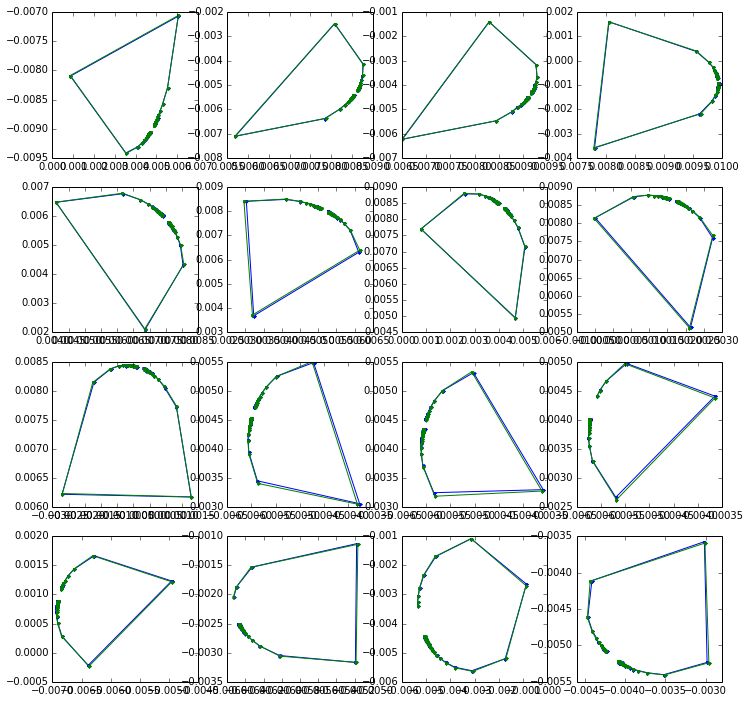

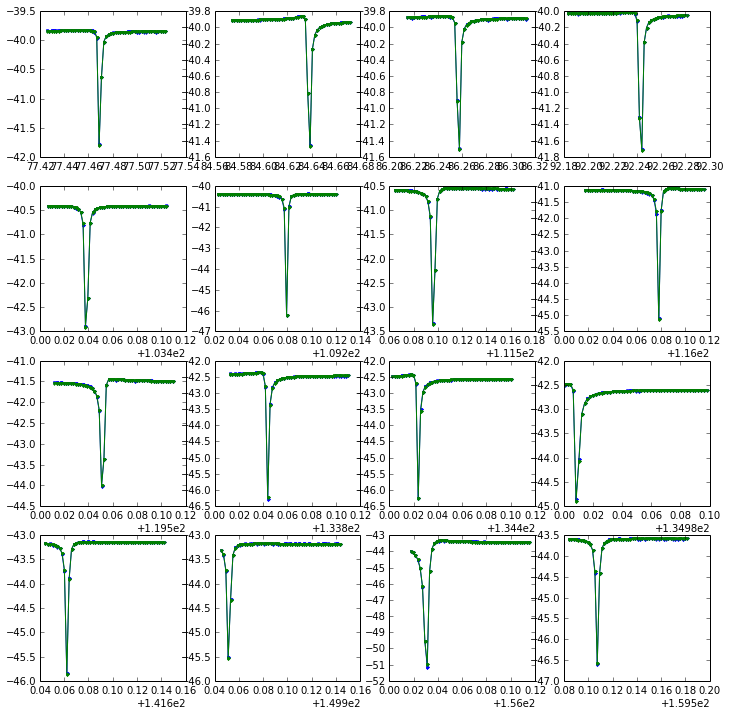

In [44]:
rrs = fit_sweeps(swp)

In [48]:
updated_f0s = np.array([rr.f_0 for rr in rrs])
Qs = np.array([rr.Q for rr in rrs])
fwhm = updated_f0s/(2*Qs)
(updated_f0s - res)*1e3

array([-35.06750832, -13.91888553, -36.66000329, -17.93136892,
       -46.5287526 , -20.50731827, -45.48316472, -16.599514  ,
       -38.41844133, -46.69816729, -57.30882928, -69.44624513,
       -59.42814741, -72.0876856 , -65.10822304, -54.09593764])

In [50]:
1e6*fwhm

array([  610.16408818,   654.81923674,   692.95945017,   747.2017651 ,
         971.76474885,   917.11035636,  1028.67225524,   965.74966214,
        1081.39736623,  1090.98837473,  1056.09273307,  1053.90375003,
        1164.70213428,  1268.83807078,  2643.59664123,  1397.41224918])

In [53]:
nsamp = 2**20
df = 256./nsamp
blah = kid_readout.utils.sweeps.prepare_sweep(ri,center_freqs=updated_f0s,offsets=np.arange(-16,16)*df,
                                       nsamp=nsamp)

bank_offset= 0 start_offset= 0 start_offset_bytes= 0
writing DRAM bank 0

writing DRAM bank 1



array([[  77.46533203,   84.63378906,   86.25292969,   92.23925781,
         103.43457031,  109.27539062,  111.59277344,  116.07470703,
         119.54785156,  133.83935547,  134.41992188,  134.98486328,
         141.65869141,  149.94775391,  156.02734375,  159.60351562],
       [  77.46582031,   84.63378906,   86.25292969,   92.23925781,
         103.43457031,  109.27587891,  111.59277344,  116.07519531,
         119.54833984,  133.83984375,  134.41992188,  134.98486328,
         141.65869141,  149.94824219,  156.02734375,  159.60400391],
       [  77.46582031,   84.63427734,   86.25341797,   92.23974609,
         103.43505859,  109.27587891,  111.59326172,  116.07519531,
         119.54833984,  133.83984375,  134.42041016,  134.98535156,
         141.65917969,  149.94824219,  156.02783203,  159.60400391],
       [  77.46630859,   84.63427734,   86.25341797,   92.23974609,
         103.43505859,  109.27636719,  111.59326172,  116.07568359,
         119.54882812,  133.84033203,  134.42

In [54]:
tic = time.time()
fine = kid_readout.utils.sweeps.do_prepared_sweep(ri,nchan_per_step=16)
print time.time()-tic

detected mcnt overflow None 565312 0 16384 0 448 565312
24.6088531017


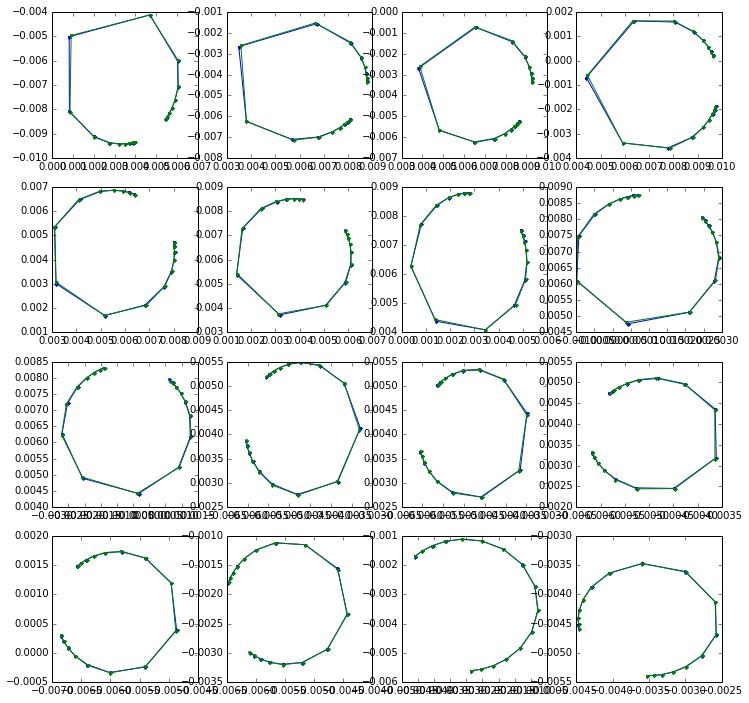

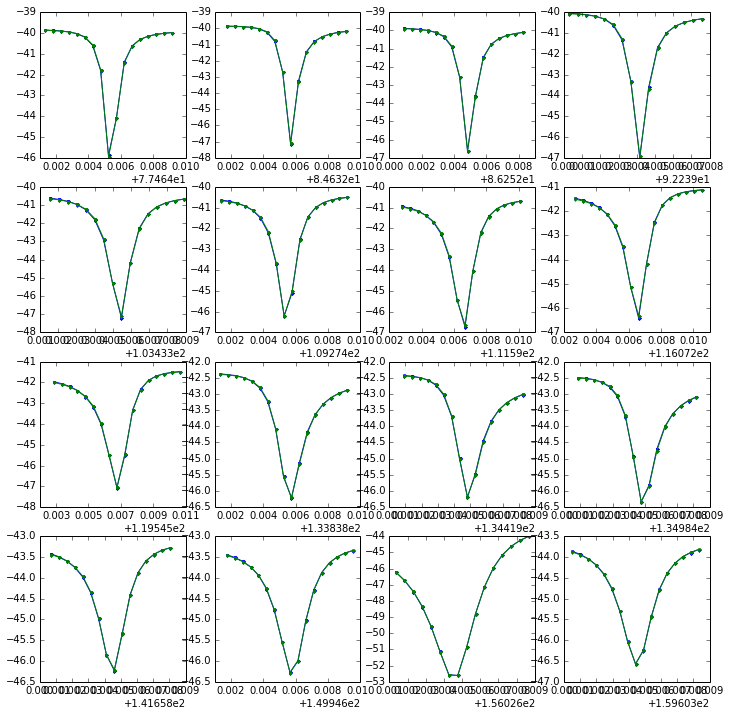

In [55]:
new_rrs = fit_sweeps(fine)

In [57]:
updated_f0s = np.array([rr.f_0 for rr in new_rrs])
Qs = np.array([rr.Q for rr in rrs])
fwhm = updated_f0s/(2*Qs)
(updated_f0s - res)*1e3

array([-35.0496255 , -13.88331871, -36.63058436, -17.89304892,
       -46.49042411, -20.50955694, -45.44570147, -16.56349086,
       -38.38461763, -46.69317507, -57.31888077, -69.44490019,
       -59.4212877 , -72.07859587, -65.08288772, -54.10325172])

In [59]:
ri.set_tone_freqs(updated_f0s,nsamp=2**20)

bank_offset= 0 start_offset= 0 start_offset_bytes= 0
writing DRAM bank 0



array([  77.46923828,   84.63769531,   86.25683594,   92.24316406,
        103.43847656,  109.27929688,  111.59667969,  116.07861328,
        119.55175781,  133.84326172,  134.42382812,  134.98876953,
        141.66259766,  149.95166016,  156.03125   ,  159.60742188])

In [60]:
ri.select_fft_bins(range(16))

In [85]:
ri.set_dac_atten(35)

In [86]:
d2,addr = ri.get_data_seconds(60)

detected mcnt overflow None 1613888 0 16384 0 14640 1613888
detected mcnt overflow None 1613888 0 32768 1 31024 1613888
detected mcnt overflow None 1613888 0 49152 2 47408 1613888
detected mcnt overflow None 1613888 0 65536 3 63792 1613888


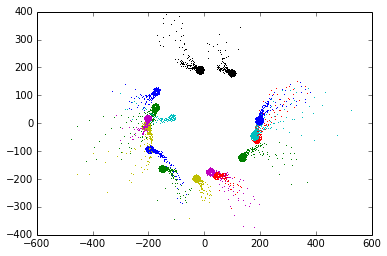

In [63]:
plot(d.real,d.imag,',')

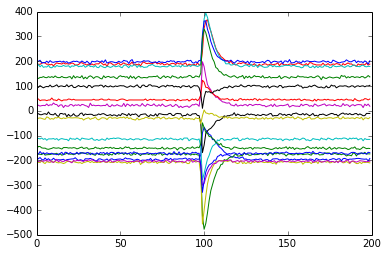

In [71]:
plot(d.real[150100:150300,:])

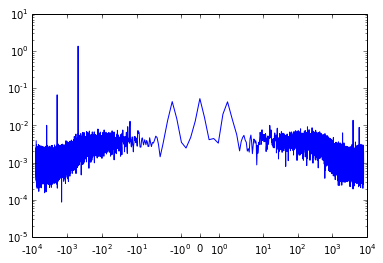

In [73]:
pxx,fr = mlab.psd(d[:,0]-d[:,0].mean(),NFFT=2**16,Fs=256e6/2.**14)
semilogy(fr,pxx)
xscale('symlog')

In [74]:
import kid_readout.analysis.iqnoise
import kid_readout.utils.despike

In [76]:
kid_readout.utils.despike.deglitch_window?

10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10


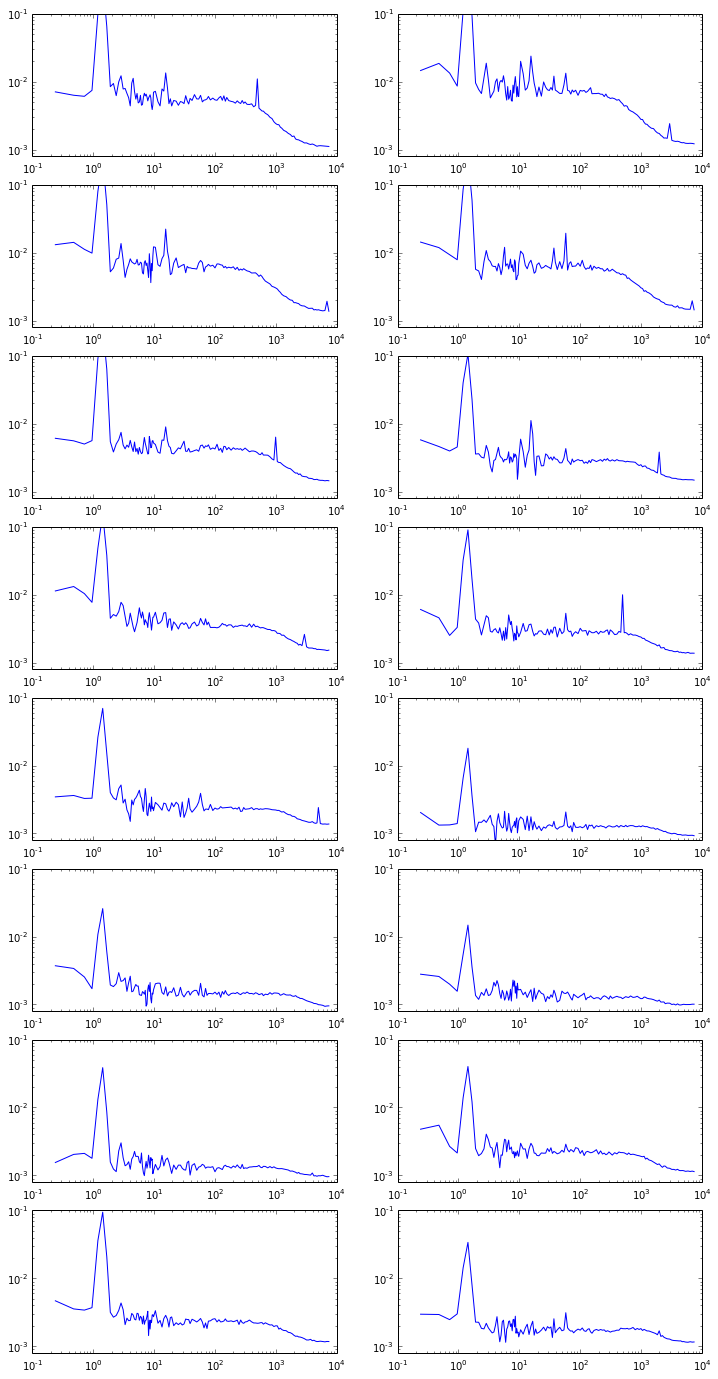

In [87]:
dmod=d2
fig,axs = subplots(8,2,figsize=(12,12*2))
for k in range(16):
    ax = axs.flatten()[k]
    despike = kid_readout.utils.despike.deglitch_window(dmod[:,k]-dmod[:,k].mean(),2**14,thresh=5)
    fr,S,evals,evects,angles,piq=kid_readout.analysis.iqnoise.pca_noise(despike,Fs=256e6/2**14,NFFT=2**16)
    ax.loglog(fr,evals[1,:])
    ax.set_ylim(.8e-3,1e-1)